## Library Setup

In [1]:
# General
import pickle
import itertools
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

# Pandas
import pandas as pd
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.family"] = "Sans"
plt.style.use('seaborn-poster')



# Seaborn
import seaborn as sns
sns.set()

# Sklearn
from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV,train_test_split,cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import LocalOutlierFactor 
from sklearn.preprocessing import scale,StandardScaler, MinMaxScaler,Normalizer,RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier

# Sklearn Metrics and Evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import  accuracy_score, f1_score, precision_score,confusion_matrix, recall_score, roc_auc_score


# LightGBM
from lightgbm import LGBMClassifier

#XGBoost
from xgboost import XGBClassifier

# CatBoost
from catboost import CatBoostClassifier

# Statistics Testing
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

import scikitplot as skplt

## Function Setup
Functions are handy tools for data operations. They turn common steps and commands into reusable pieces of code. This makes programming easier and less repetitive. Using functions also helps to speed up data operations and improve the workflow.

### Dataset Information, Feature Checking, and Analysis

In [2]:
def dataInfo(X):
    print('='*10, 'DATA & FEATURE INFORMATION', '='*10)
    print(f'Data Rows: {X.shape[0]}')
    print(f'Data Columns: {X.shape[1]}')
    print(f'Duplicated Values: {X.duplicated().sum()}')
    missing_val = X.isnull().sum()
    missing_val_percentage = missing_val/len(X)*100
    data_type = X.dtypes
    unique_val = X.nunique()
    return pd.DataFrame({
        'Missing_val' : missing_val,
        'Missing_percentage' : missing_val_percentage,
        'Data_type' : data_type,
        'Unique_values' : unique_val
    }).sort_values('Missing_percentage',ascending=False)

### Checking Outlier in Data and Returning It

In [3]:
def dataOutlier(X, col):
    q1 = X[col].quantile(0.25) # Finding the first quartile
    q3 = X[col].quantile(0.75) # Finding the third quartile
    iqr_val = stats.iqr(X[col]) # Finding the interquartile range
    lower = q1 - (1.5*iqr_val) # Lower limit for detecting outliers in the data
    upper = q3 + (1.5*iqr_val) # Upper limit for detecting outliers in the data
    
    outlier_list = X[col].apply(lambda x: 'outlier' if x < lower or x > upper else 'not-outlier')
    print(f'outlier lower limit: {lower}\noutlier upper limit: {upper}')
    return outlier_list


### Checking Outlier Using LOF method

In [4]:
def lof_observation(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_num_cols = df.select_dtypes(include=numerics)
    df_outlier = df_num_cols.astype("float64")
    clf = LocalOutlierFactor(n_neighbors = 20, contamination = 0.1)
    clf.fit_predict(df_outlier)
    df_scores = clf.negative_outlier_factor_
    scores_df = pd.DataFrame(np.sort(df_scores))
    
    scores_df.plot(stacked=True, xlim = [0,20], color='r', title='Visualization of outliers according to the LOF method', style = '.-');                # first 20 observe
    th_val = np.sort(df_scores)[2]
    outliers = df_scores > th_val
    df = df.drop(df_outlier[~outliers].index)
    df.shape
    return df

### Returning Unique Values in Data

In [5]:
def dataUnique(X):
    for x in X.columns:
        print(f'========== {x} ==========')
        print(f'{X[x].unique()}\n') # Printing all the unique values in the columns

### Data Visualization (Used Mostly to See The Data Distribution and Outlier Existence)

In [6]:
def hist_boxplot(df, x_col, y_col=None, hue_col=None):
    color = '#F84030'
    if y_col is None: 
        plt.figure(figsize=(10,10))
        plt.subplot(211)
        sns.boxplot(data=df, x=x_col, color=color)
        
        plt.subplot(212)
        sns.histplot(data=df, x=x_col, color=color)
        plt.tight_layout()
        plt.show()
        
    elif hue_col is None:
        plt.figure(figsize=(10,10))
        plt.subplot(211)
        sns.boxplot(data=df, x=x_col, y=y_col, color=color)
        
        plt.subplot(212)
        sns.histplot(data=df, x=x_col, y=y_col, color=color)
        plt.tight_layout()
        plt.show()
        
    else:
        plt.figure(figsize=(10,10))
        plt.subplot(211)
        sns.boxplot(data=df, x=x_col, y=y_col, hue=hue_col, color=color)
        
        plt.subplot(212)
        sns.histplot(data=df, x=x_col, y=y_col, hue=hue_col, color=color)
        plt.tight_layout()
        plt.show()

### Another Data Visualization (Used to See The Corelation of Certain Variable, Mostly Between Predictor and Target)

In [7]:
#catergoric vs categoric
#predictor,target
def plot_category_category(df, predictor, target):
    ax = ((df.groupby([predictor])[target].mean())/((df.groupby([predictor])[target].mean()).sum())*100).plot(kind='bar',figsize=(10,8), color = '#F84030')
    abs_values = round(((df.groupby([predictor])[target].mean())/((df.groupby([predictor])[target].mean()).sum())*100),1)
    ax.bar_label(container=ax.containers[0], labels=abs_values)  

    plt.xticks(rotation=0);
    plt.ylabel('Churn Rate (%)',fontsize=12)
    plt.title(f'{predictor} vs Churn Rate (%)',fontsize=12)
    plt.xlabel(predictor,fontsize=12)
    plt.ylim(0,100)

    plt.show()

In [8]:
def plot_num_category(df, numeric, category):
    ax = (df.groupby([category])[numeric].median()).plot(kind='bar',figsize=(10,8), color = '#F84030')
    abs_values = round((df.groupby([category])[numeric].median()),1)
    ax.bar_label(container=ax.containers[0], labels=abs_values)
    
    plt.title(f'{numeric} vs {category}',fontsize=12)
    plt.ylabel(category,fontsize=12)
    plt.xlabel(numeric,fontsize=12)
    plt.xticks(rotation=0)
    plt.ylim(0,max(abs_values)+100)
    plt.show()

### Statistical Analysis (Analysis of Variance and Chi-Square Test)
ANOVA (analysis of variance) is a statistical test that compares the means of multiple groups to determine if there are significant differences between them. The chi-square test is a statistical test that compares observed frequencies in a sample to expected frequencies in a population to determine if there is a significant difference between them.

ANOVA is used for continuous data and assumes normality and equal variances, while the chi-square test is used for categorical data and makes no assumptions about the data. ANOVA produces an F-value and p-value, while the chi-square test produces a chi-square statistic and p-value.

In [9]:
def anova(df, predictor_col, target_col):
    group1 = df[df[target_col]==1][predictor_col]
    group2 = df[df[target_col]==0][predictor_col]

    alpha = 0.05
    ftest, p_value = f_oneway(group1, group2)

    if p_value < alpha:
        print(f'Conclusion: p-value {p_value} is less than alpha {alpha}, ftest = {ftest}')
        print('There is a significant difference in the target based on the predictor.')
        print()
    else:
        print(f'Conclusion: p-value {p_value} is greater than alpha {alpha}, ftest = {ftest}')
        print('There is no significant difference in the target based on the predictor.')
        print()

In [10]:
def chi_test(df, predictor_col, target_col):
    obs = pd.crosstab(df[predictor_col], df[target_col])
    chi2, p, dof, expected = chi2_contingency(obs)
    alpha = 0.05

    if p < alpha:
        print(f'===== {predictor_col} =====')
        print('Number Expected:')
        print(expected)
        print()
        print(f'Chi-square Statistic: {chi2}, p-value: {p} less than {alpha}')
        print('There is a significant difference in the target based on the predictor.')
        print()
    else:
        print(f'===== {predictor_col} =====')
        print('Number Expected:')
        print(expected)
        print()
        print(f'Chi-square Statistic: {chi2}, p-value: {p} greater than {alpha}')
        print('There is no significant difference in the target based on the predictor.')
        print()

## Data Preparation

### Import Data

In [11]:
data = pd.read_csv('data/churn.csv')

In [12]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00000,1,1,1,101348.88000,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86000,1,0,1,112542.58000,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80000,3,1,0,113931.57000,1
3,4,15701354,Boni,699,France,Female,39,1,0.00000,2,0,0,93826.63000,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82000,1,1,1,79084.10000,0


## Data Checking

### Checking for The Data Dimension, Missing Data, and Wrong Input in Data

In [13]:
dataInfo(data)

========== DATA & FEATURE INFORMATION ==========
Data Rows: 10000
Data Columns: 14
Duplicated Values: 0


,Missing_val,Missing_percentage,Data_type,Unique_values
RowNumber,0,0.00000,int64,10000
CustomerId,0,0.00000,int64,10000
Surname,0,0.00000,object,2932
CreditScore,0,0.00000,int64,460
Geography,0,0.00000,object,3
Gender,0,0.00000,object,2
Age,0,0.00000,int64,70
Tenure,0,0.00000,int64,11
Balance,0,0.00000,float64,6382
NumOfProducts,0,0.00000,int64,4


In [14]:
dataUnique(data)

========== RowNumber ==========
[    1     2     3 ...  9998  9999 10000]

========== CustomerId ==========
[15634602 15647311 15619304 ... 15584532 15682355 15628319]

========== Surname ==========
['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']

========== CreditScore ==========
[619 608 502 699 850 645 822 376 501 684 528 497 476 549 635 616 653 587
 726 732 636 510 669 846 577 756 571 574 411 591 533 553 520 722 475 490
 804 582 472 465 556 834 660 776 829 637 550 698 585 788 655 601 656 725
 511 614 742 687 555 603 751 581 735 661 675 738 813 657 604 519 664 678
 757 416 665 777 543 506 493 652 750 729 646 647 808 524 769 730 515 773
 814 710 413 623 670 622 785 605 479 685 538 562 721 628 668 828 674 625
 432 770 758 795 686 789 589 461 584 579 663 682 793 691 485 650 754 535
 716 539 706 586 631 717 800 683 704 615 667 484 480 578 512 606 597 778
 514 525 715 580 807 521 759 516 711 618 643 671 689 620 676 572 695 592
 567 694 547 594 673 610 767 763 712 703 662

### First Observation
1. The dataset consists of 10000 observations with 14 variables each
2. The data is clean and complete, with no missing or duplicated values
3. Target data is called "Exited"
4. Some data type might need changing
5. Gender and Geography can be encoded

In [15]:
TARGET = "Exited"

In [16]:
data_new = data.copy()
data_new['Tenure'] =  data_new.Tenure.astype(float)
data_new['NumOfProducts'] =  data_new.NumOfProducts.astype(float)

In [17]:
data_new.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.00000,0.00000,1.00000,1,1,101348.88000,1
1,2,15647311,Hill,608,Spain,Female,41,1.00000,83807.86000,1.00000,0,1,112542.58000,0
2,3,15619304,Onio,502,France,Female,42,8.00000,159660.80000,3.00000,1,0,113931.57000,1
3,4,15701354,Boni,699,France,Female,39,1.00000,0.00000,2.00000,0,0,93826.63000,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.00000,125510.82000,1.00000,1,1,79084.10000,0


### Data Descriptive Statistics

In [18]:
numerical = ['CreditScore',
             'Age',
             'Tenure',
             'Balance',
             'NumOfProducts',
             'EstimatedSalary']
categorical =['RowNumber',
              'CustomerId',
              'Surname',
              'Geography',
              'Gender',
              'HasCrCard',
              'IsActiveMember',
              'Exited']

In [19]:
data_new[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.00000,650.52880,96.65330,350.00000,584.00000,652.00000,718.00000,850.00000
Age,10000.00000,38.92180,10.48781,18.00000,32.00000,37.00000,44.00000,92.00000
Tenure,10000.00000,5.01280,2.89217,0.00000,3.00000,5.00000,7.00000,10.00000
Balance,10000.00000,76485.88929,62397.40520,0.00000,0.00000,97198.54000,127644.24000,250898.09000
NumOfProducts,10000.00000,1.53020,0.58165,1.00000,1.00000,1.00000,2.00000,4.00000
EstimatedSalary,10000.00000,100090.23988,57510.49282,11.58000,51002.11000,100193.91500,149388.24750,199992.48000


array([<Axes: ylabel='1'>], dtype=object)

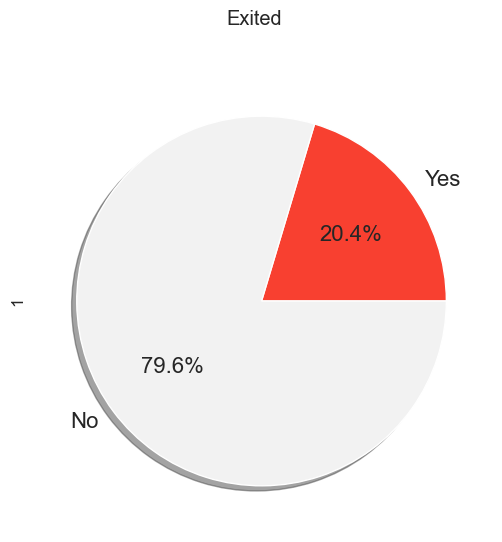

In [20]:
# Select rows where is 1 (Exited)
df_zero = data_new.query('Exited == 1')

# Count occurrences of each value
counts = df_zero['Exited'].value_counts()

plot_exited = pd.DataFrame({'Yes' : counts,'No' : len(data_new) - counts})

# Plot as pie chart
plot_exited.T.plot(kind = 'pie',subplots=True, legend =False, title = 'Exited', figsize = (6,6),colors=['#F84030','#F2F2F2'], 
        shadow=True,
        autopct='%1.1f%%',
        textprops={'fontsize': 16})

In [21]:
data_new[categorical].describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.00000,5000.50000,2886.89568,1.00000,2500.75000,5000.50000,7500.25000,10000.00000
CustomerId,10000.00000,15690940.56940,71936.18612,15565701.00000,15628528.25000,15690738.00000,15753233.75000,15815690.00000
HasCrCard,10000.00000,0.70550,0.45584,0.00000,0.00000,1.00000,1.00000,1.00000
IsActiveMember,10000.00000,0.51510,0.49980,0.00000,0.00000,1.00000,1.00000,1.00000
Exited,10000.00000,0.20370,0.40277,0.00000,0.00000,0.00000,0.00000,1.00000


In [22]:
(data_new[data_new[categorical] == 1][categorical].count())/len(data_new)*100

RowNumber         0.01000
CustomerId        0.00000
Surname           0.00000
Geography         0.00000
Gender            0.00000
HasCrCard        70.55000
IsActiveMember   51.51000
Exited           20.37000
dtype: float64

### Second Observation
1. The average credit score of the customers is 650.53, which is considered fair. 
2. The credit score ranges from 350 to 850, with 850 being the highest possible score. 
3. The average age of the customers is 38.92 years, with a minimum of 18 and a maximum of 92. 
4. The average tenure of the customers is 5.01 years, meaning they have been with the company for about 5 years on average. The tenure ranges from 0 to 10 years. 
5. The average balance of the customers is 76485.89, with a large variation of 62397.41. The balance ranges from 0 to 250898.09, with some customers having no balance at all. 
6. The average number of products used by the customers is 1.53, with a standard deviation of 0.58. The number of products ranges from 1 to 4, with most customers using either 1 or 2 products. 
7. The average estimated salary of the customers is 100090.24, with a standard deviation of 57510.49. The estimated salary ranges from 11.58 to 199992.48, with a wide distribution of values.
8. The data also shows that 20.4% of the customers exited the company, which is a high churn rate. This could indicate that the company is not meeting the needs or expectations of its customers, or that there are better alternatives in the market.
9. 70.55% customer has a credit card, 51.51% customer is an active member

## Exploratory Data Analysis

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.00000,0.00000,1.00000,1,1,101348.88000,1
1,2,15647311,Hill,608,Spain,Female,41,1.00000,83807.86000,1.00000,0,1,112542.58000,0
2,3,15619304,Onio,502,France,Female,42,8.00000,159660.80000,3.00000,1,0,113931.57000,1
3,4,15701354,Boni,699,France,Female,39,1.00000,0.00000,2.00000,0,0,93826.63000,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.00000,125510.82000,1.00000,1,1,79084.10000,0


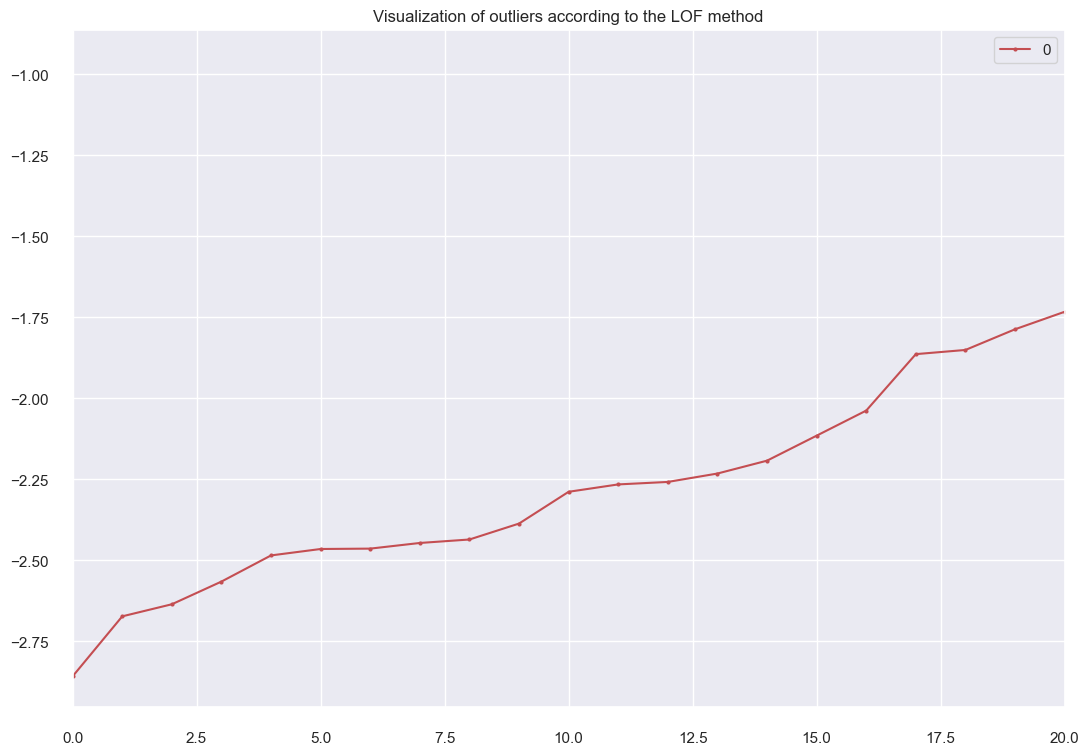

In [23]:
lof_observation(data_new).head()

### Profile Analysis of The Costumer

#### 1. CreditScore vs Exited

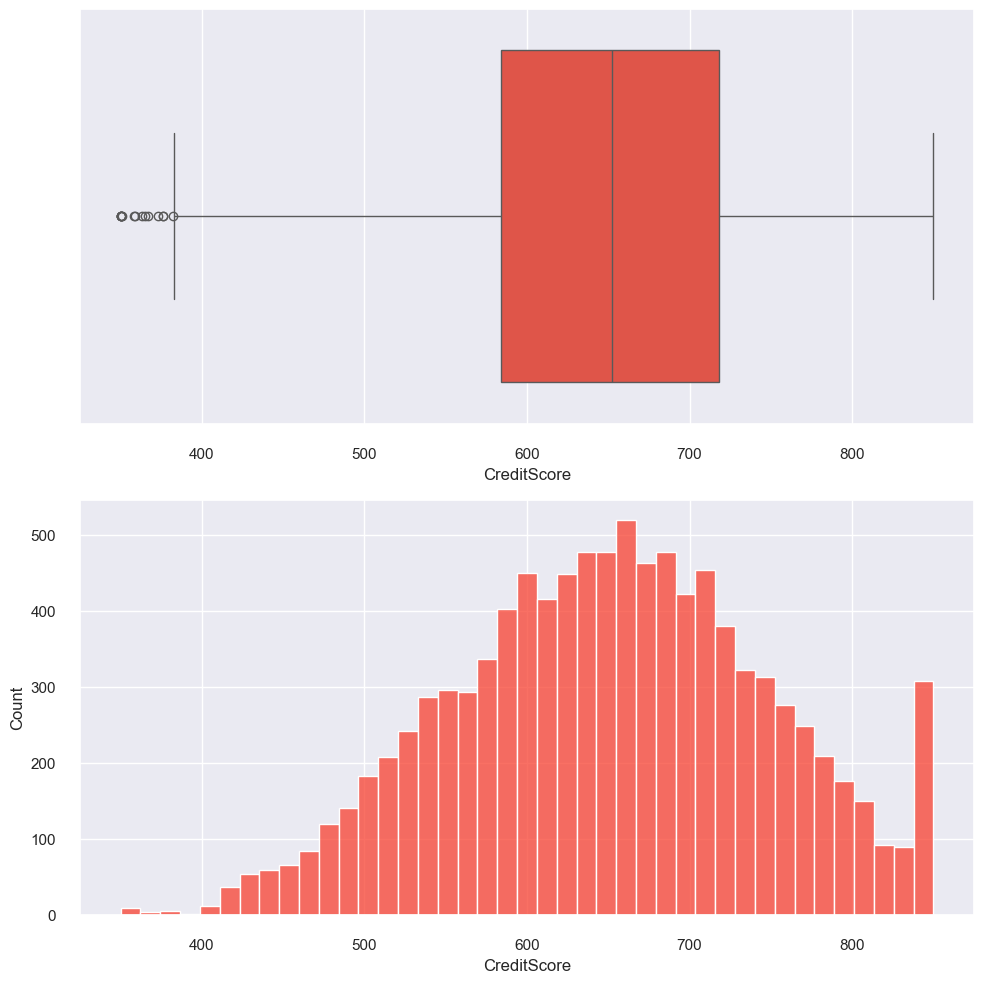

In [24]:
hist_boxplot(data_new,'CreditScore')

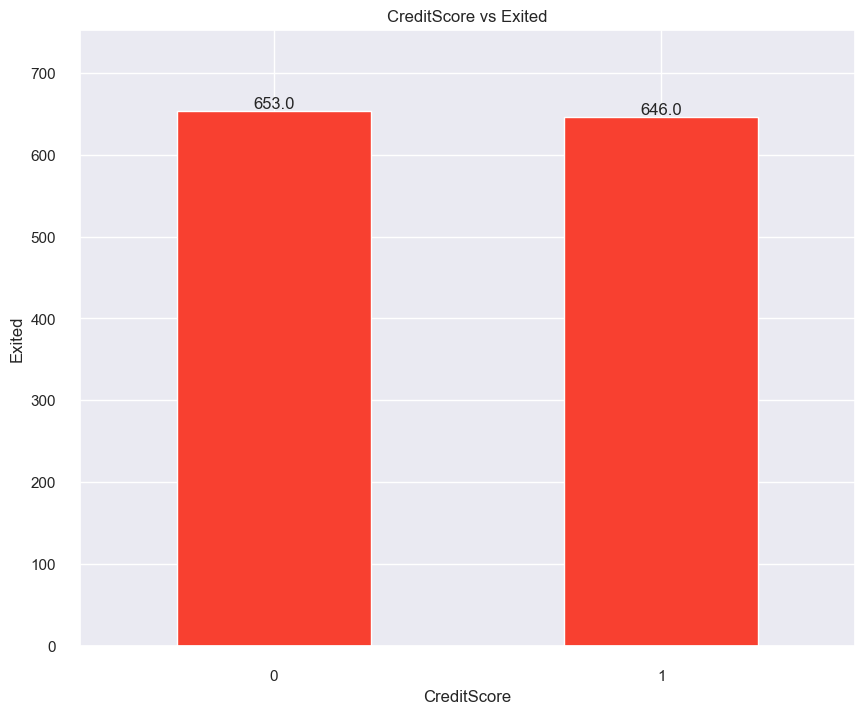

In [25]:
plot_num_category(data_new,'CreditScore',TARGET)

In [26]:
anova(data_new,'CreditScore',TARGET)

Conclusion: p-value 0.006738213892205325 is less than alpha 0.05, ftest = 7.344522163758249
There is a significant difference in the target based on the predictor.



In [27]:
dataOutlier(data_new, 'CreditScore')

outlier lower limit: 383.0
outlier upper limit: 919.0


0       not-outlier
1       not-outlier
2       not-outlier
3       not-outlier
4       not-outlier
5       not-outlier
6       not-outlier
7           outlier
8       not-outlier
9       not-outlier
10      not-outlier
11      not-outlier
12      not-outlier
13      not-outlier
14      not-outlier
15      not-outlier
16      not-outlier
17      not-outlier
18      not-outlier
19      not-outlier
20      not-outlier
21      not-outlier
22      not-outlier
23      not-outlier
24      not-outlier
25      not-outlier
26      not-outlier
27      not-outlier
28      not-outlier
29      not-outlier
30      not-outlier
31      not-outlier
32      not-outlier
33      not-outlier
34      not-outlier
35      not-outlier
36      not-outlier
37      not-outlier
38      not-outlier
39      not-outlier
40      not-outlier
41      not-outlier
42      not-outlier
43      not-outlier
44      not-outlier
45      not-outlier
46      not-outlier
47      not-outlier
48      not-outlier
49      not-outlier


#### Obervation
1. Outlier present
2. Lower credit score could corelated with Exited based on statistical testing

#### 2. Age vs Exited

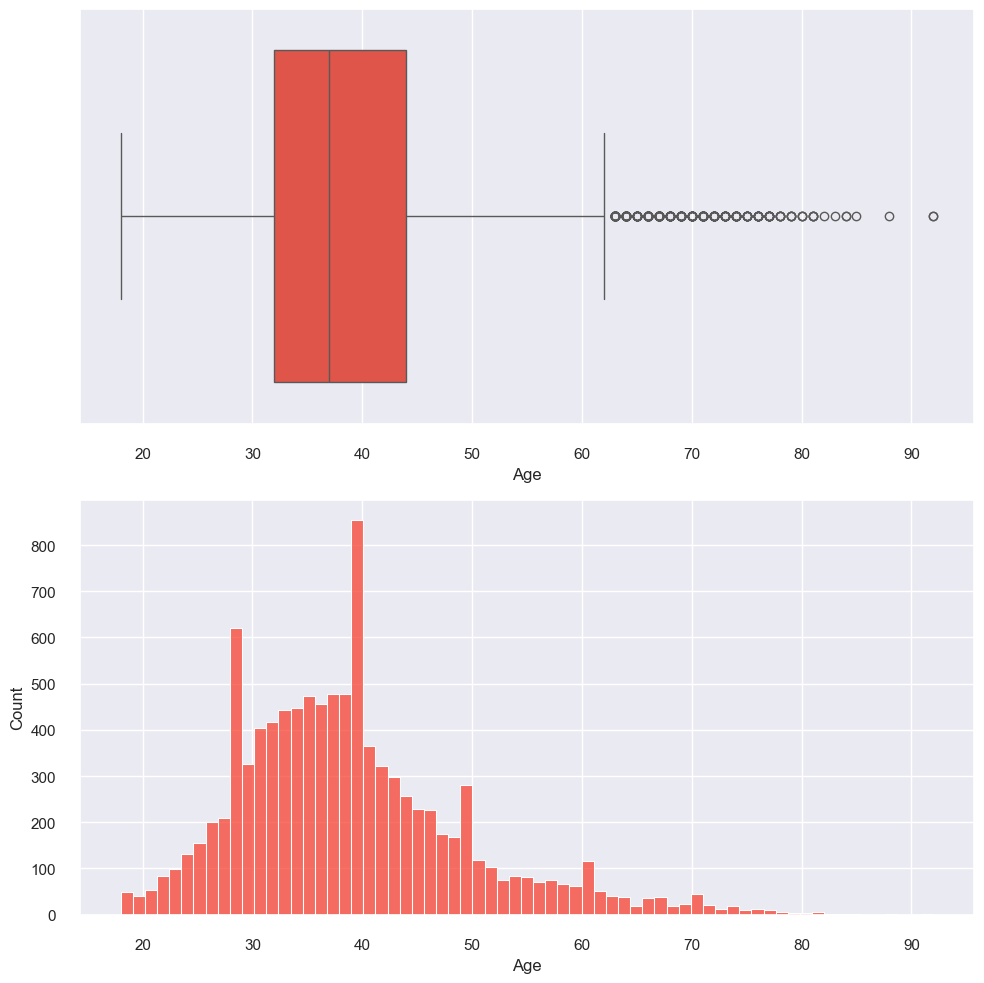

In [28]:
hist_boxplot(data_new,'Age')

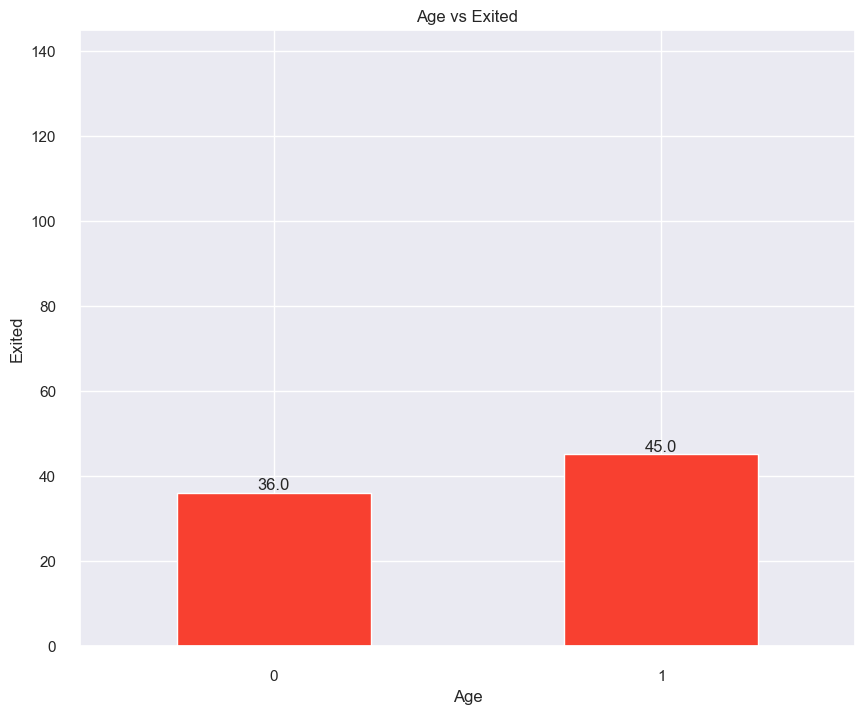

In [29]:
plot_num_category(data_new,'Age',TARGET)

In [30]:
anova(data_new,'Age',TARGET)

Conclusion: p-value 1.2399313093445346e-186 is less than alpha 0.05, ftest = 886.0632749090969
There is a significant difference in the target based on the predictor.



In [31]:
dataOutlier(data_new, 'Age')

outlier lower limit: 14.0
outlier upper limit: 62.0


0       not-outlier
1       not-outlier
2       not-outlier
3       not-outlier
4       not-outlier
5       not-outlier
6       not-outlier
7       not-outlier
8       not-outlier
9       not-outlier
10      not-outlier
11      not-outlier
12      not-outlier
13      not-outlier
14      not-outlier
15      not-outlier
16      not-outlier
17      not-outlier
18      not-outlier
19      not-outlier
20      not-outlier
21      not-outlier
22      not-outlier
23      not-outlier
24      not-outlier
25      not-outlier
26      not-outlier
27      not-outlier
28      not-outlier
29      not-outlier
30      not-outlier
31      not-outlier
32      not-outlier
33      not-outlier
34      not-outlier
35      not-outlier
36      not-outlier
37      not-outlier
38      not-outlier
39      not-outlier
40      not-outlier
41      not-outlier
42      not-outlier
43      not-outlier
44      not-outlier
45      not-outlier
46      not-outlier
47      not-outlier
48      not-outlier
49      not-outlier


#### Observation
1. Outlier present
2. Older customer more likely to exit the bank

#### 3. Tenure vs Exited

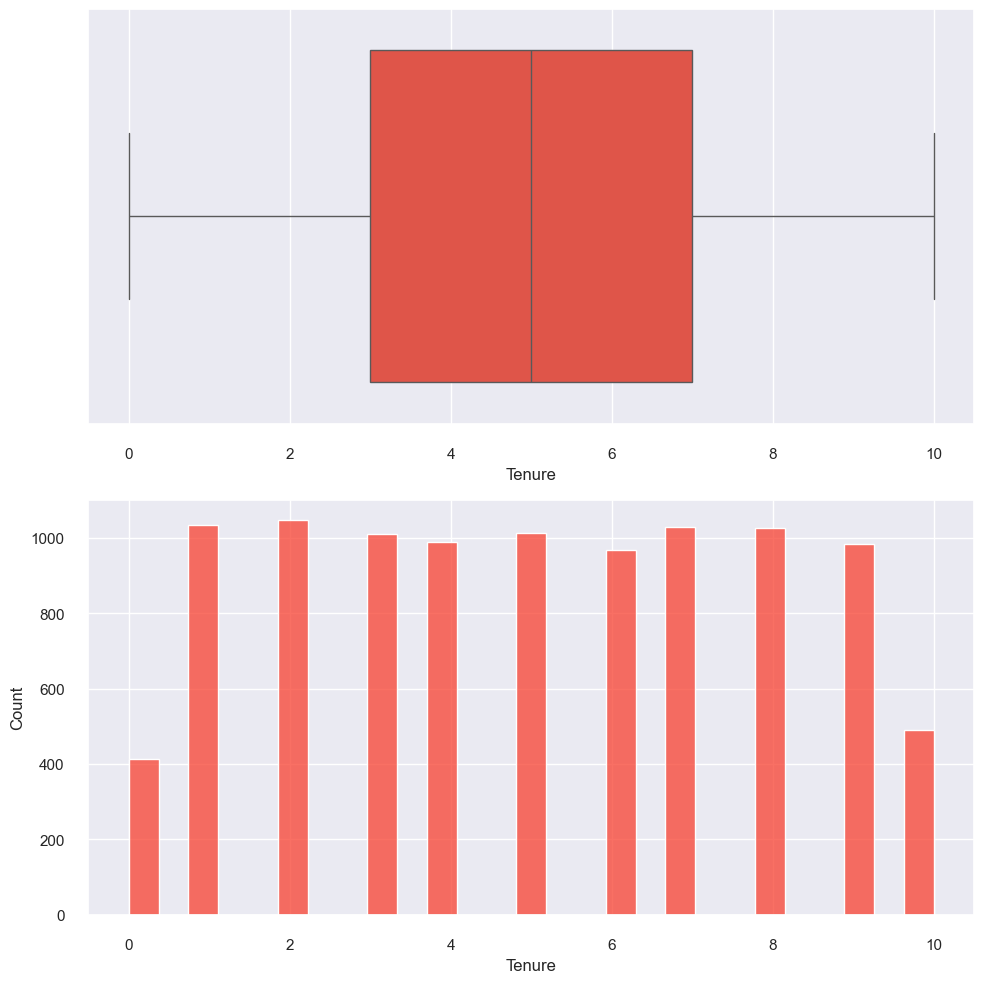

In [32]:
hist_boxplot(data_new,'Tenure')

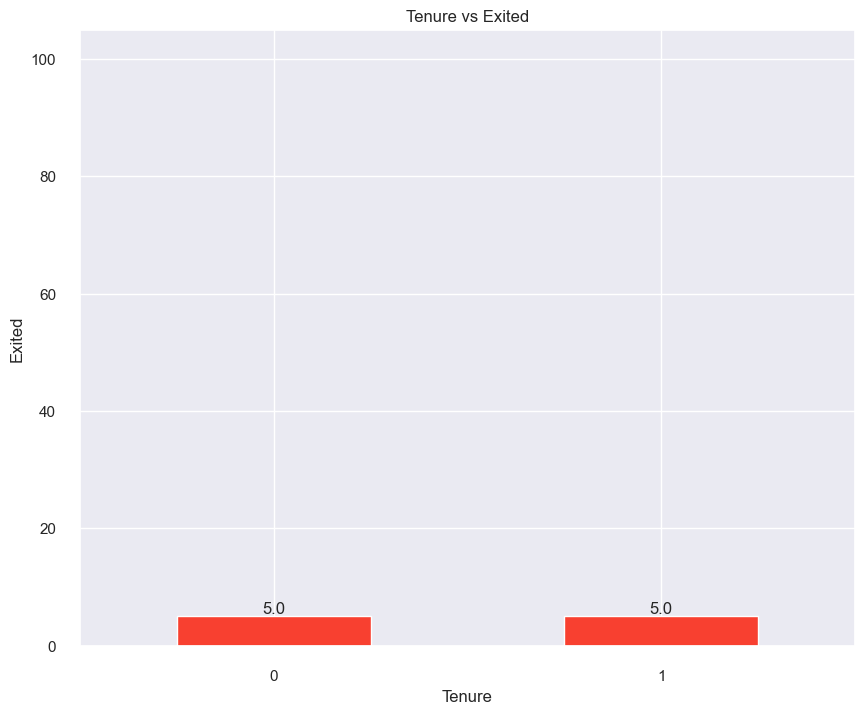

In [33]:
plot_num_category(data_new,'Tenure',TARGET)

In [34]:
anova(data_new,'Tenure',TARGET)

Conclusion: p-value 0.1615268494946745 is greater than alpha 0.05, ftest = 1.960163626100812
There is no significant difference in the target based on the predictor.



#### Observation
1. Tenure not likely corelated with exited

#### 4. NumOfProducts vs Exited

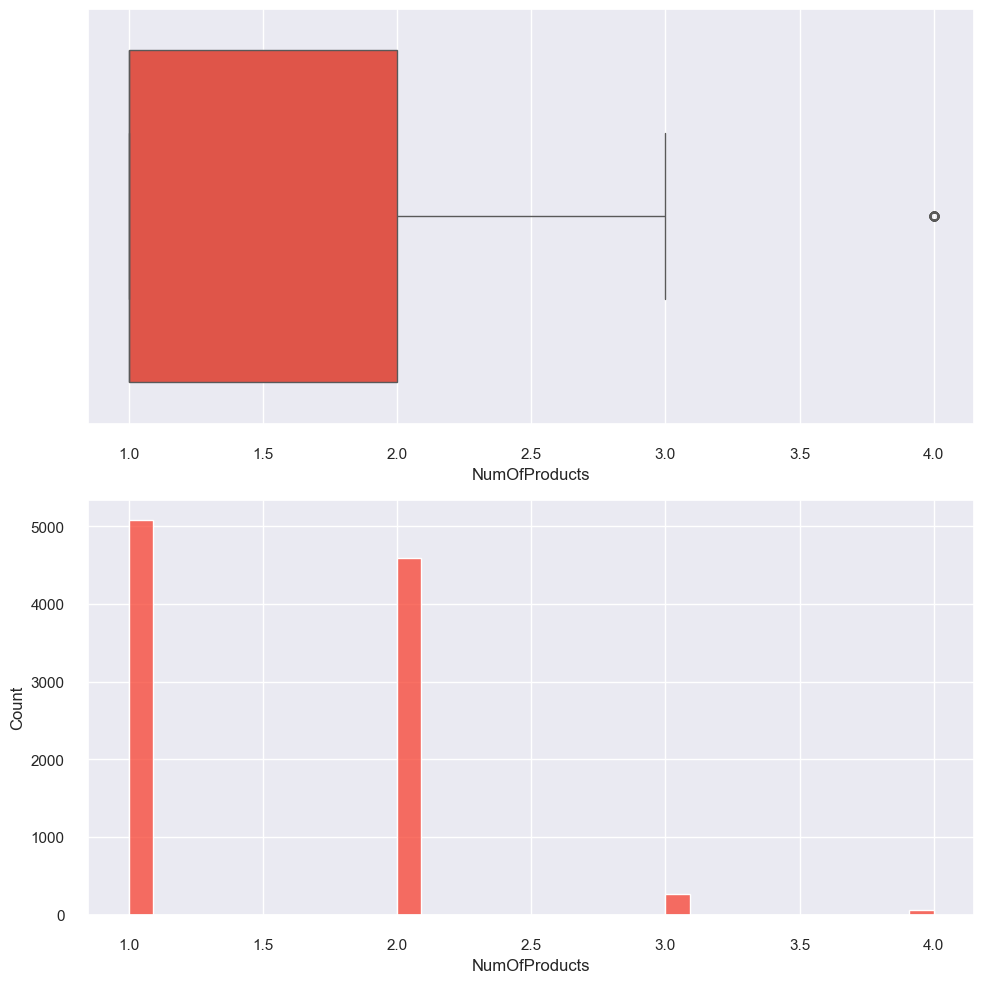

In [35]:
hist_boxplot(data_new,'NumOfProducts')

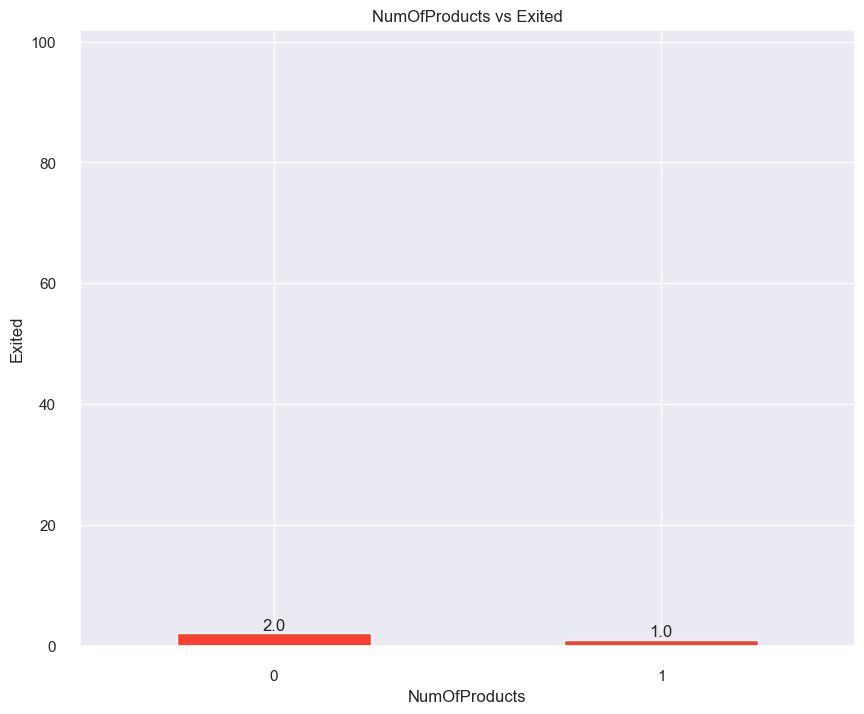

In [36]:
plot_num_category(data_new,'NumOfProducts',TARGET)

In [37]:
anova(data_new,'NumOfProducts',TARGET)

Conclusion: p-value 1.717333004806199e-06 is less than alpha 0.05, ftest = 22.9152225029369
There is a significant difference in the target based on the predictor.



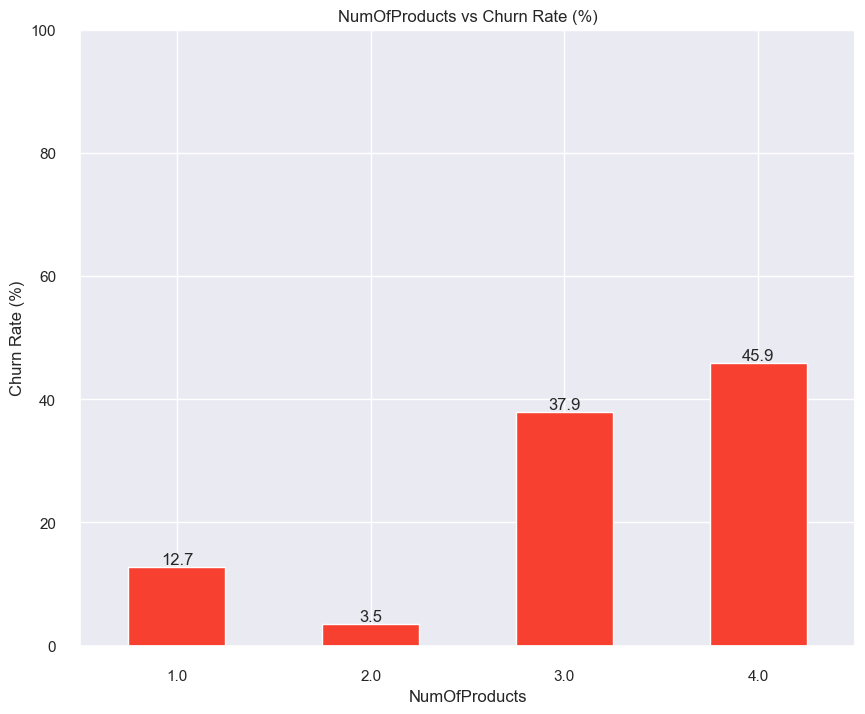

In [38]:
plot_category_category(data_new,'NumOfProducts',TARGET)

In [39]:
chi_test(data_new,'NumOfProducts', TARGET)

===== NumOfProducts =====
Number Expected:
[[4048.3892 1035.6108]
 [3655.017   934.983 ]
 [ 211.8158   54.1842]
 [  47.778    12.222 ]]

Chi-square Statistic: 1503.6293615070408, p-value: 0.0 less than 0.05
There is a significant difference in the target based on the predictor.



#### Observation
1. Customer using Product 3 and 4 are more likely to exit the bank

#### 5. EstimatedSalary vs Exited

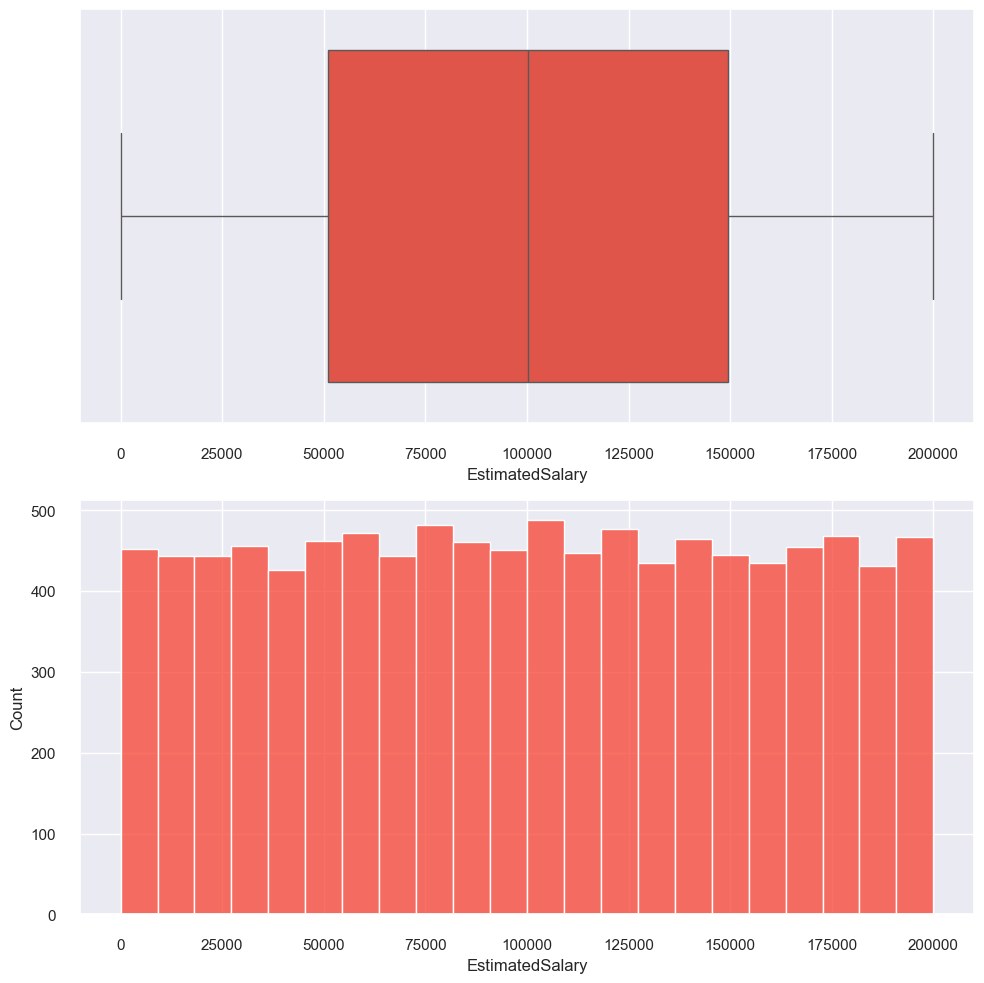

In [40]:
hist_boxplot(data_new,'EstimatedSalary')

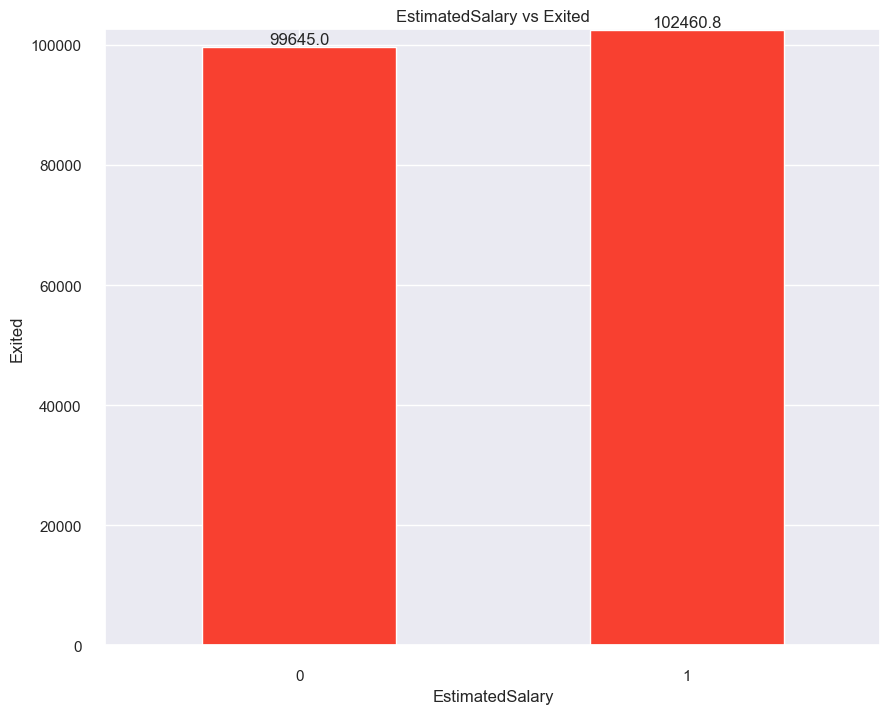

In [41]:
plot_num_category(data_new,'EstimatedSalary',TARGET)

In [42]:
anova(data_new,'EstimatedSalary',TARGET)

Conclusion: p-value 0.22644042802263928 is greater than alpha 0.05, ftest = 1.463261923973248
There is no significant difference in the target based on the predictor.



#### Observation
1. Salary doesnt corelate with exited

#### 6. Geography vs Exited

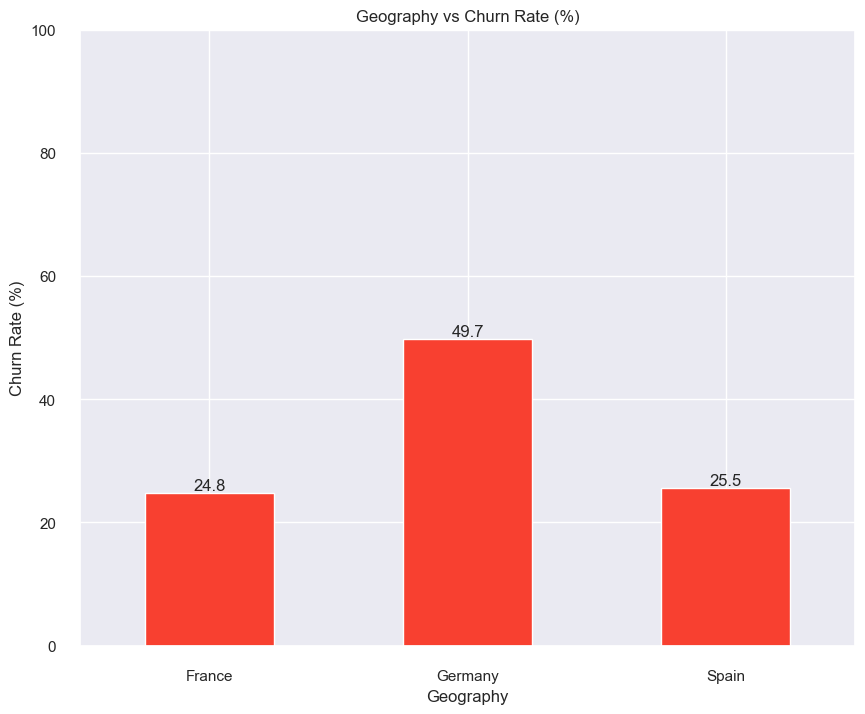

In [43]:
plot_category_category(data_new,'Geography',TARGET)

In [44]:
chi_test(data_new,'Geography', TARGET)

===== Geography =====
Number Expected:
[[3992.6482 1021.3518]
 [1997.9167  511.0833]
 [1972.4351  504.5649]]

Chi-square Statistic: 301.25533682434536, p-value: 3.8303176053541544e-66 less than 0.05
There is a significant difference in the target based on the predictor.



#### Observation
1. Customer from Germany are more likely to leave the bank

#### 7. HasCrCard vs Exited

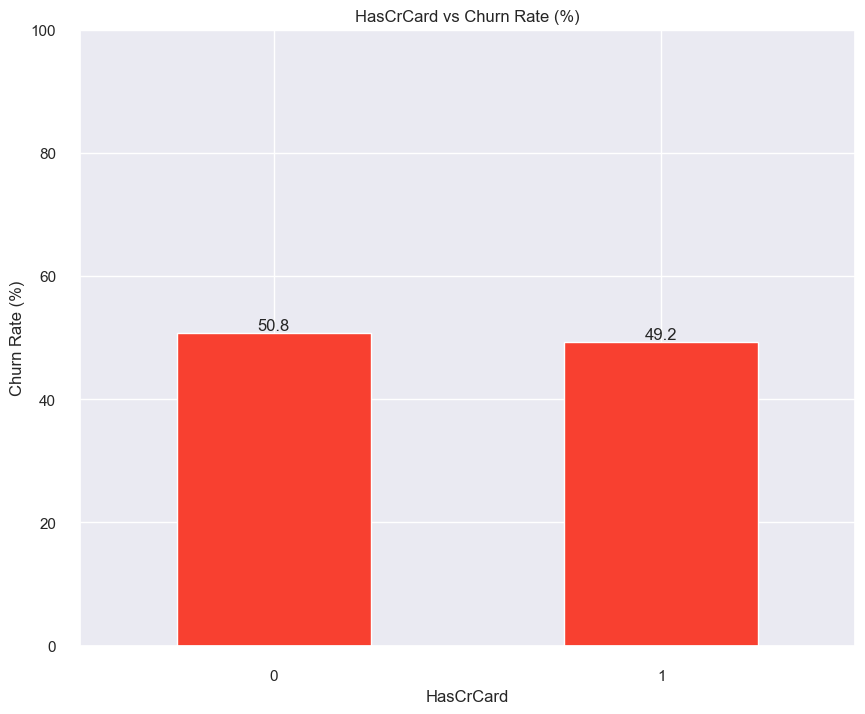

In [45]:
plot_category_category(data_new,'HasCrCard',TARGET)

In [46]:
chi_test(data_new,'HasCrCard', TARGET)

===== HasCrCard =====
Number Expected:
[[2345.1035  599.8965]
 [5617.8965 1437.1035]]

Chi-square Statistic: 0.47133779904440803, p-value: 0.49237236141554697 greater than 0.05
There is no significant difference in the target based on the predictor.



#### Obersvation
1. Owning credit card or not doesnt have significant impact to customer exiting the bank

#### 8. IsActiveMember vs Exited

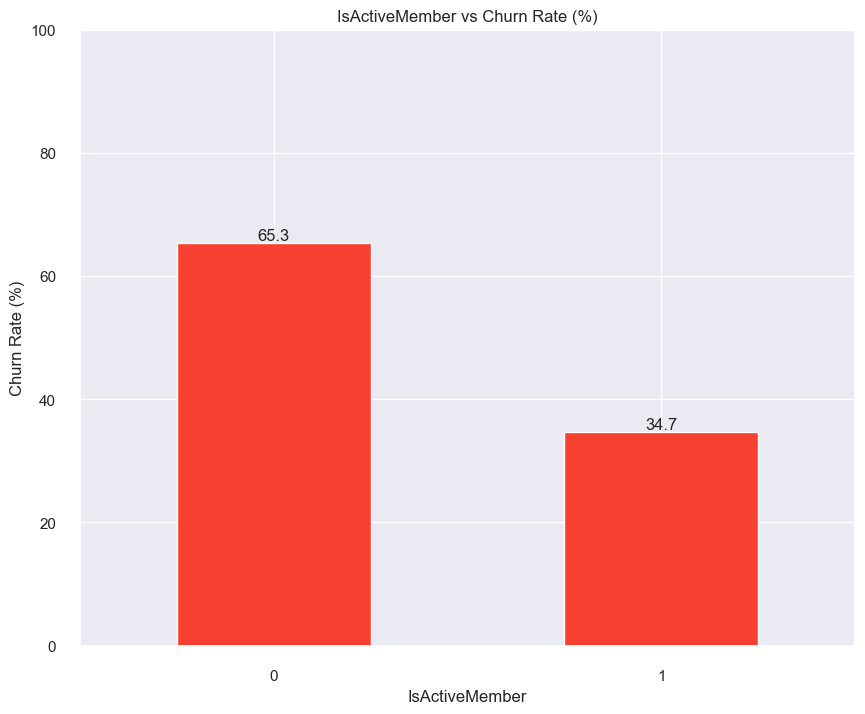

In [47]:
plot_category_category(data_new,'IsActiveMember',TARGET)

In [48]:
chi_test(data_new,'IsActiveMember', TARGET)

===== IsActiveMember =====
Number Expected:
[[3861.2587  987.7413]
 [4101.7413 1049.2587]]

Chi-square Statistic: 242.98534164287963, p-value: 8.785858269303705e-55 less than 0.05
There is a significant difference in the target based on the predictor.



#### Observation
1. Active member are not likely to exit the bank

#### 9.Gender vs Exited

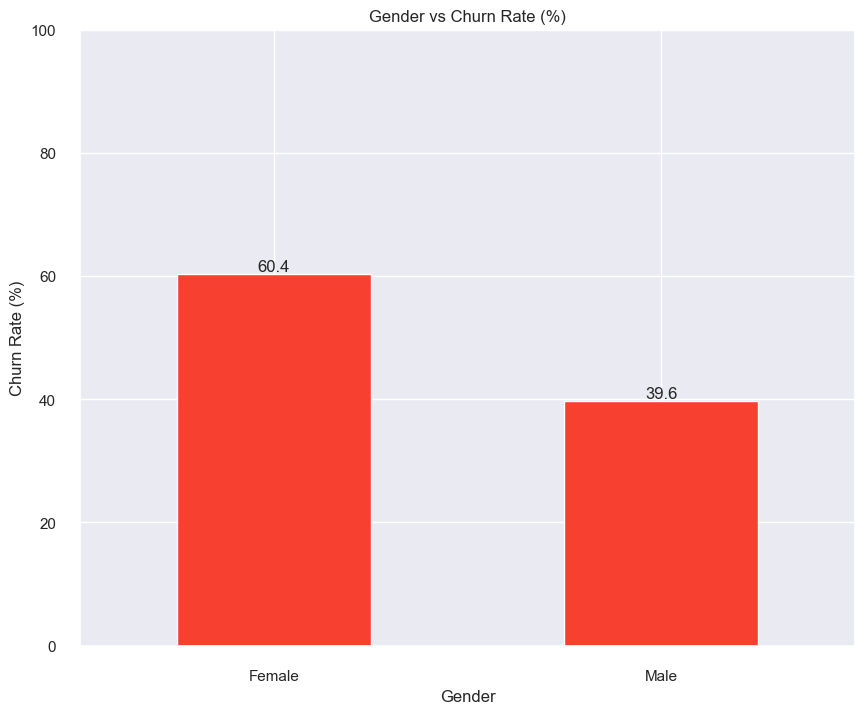

In [49]:
plot_category_category(data_new,'Gender',TARGET)

In [50]:
chi_test(data_new,'Gender', TARGET)

===== Gender =====
Number Expected:
[[3617.5909  925.4091]
 [4345.4091 1111.5909]]

Chi-square Statistic: 112.91857062096116, p-value: 2.2482100097131755e-26 less than 0.05
There is a significant difference in the target based on the predictor.



#### Observation
1. Female customer are likely to leave the bank

### Outlier Removal and Data Cleaning

In [51]:
def clear_outliers(df):
    # Suppress age and credit score
    for col in ["Age", "CreditScore"]:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        print(f"When {col} is printed below lower score: {lower} and upper score: {upper}")
        if col == "Age":
            df_outlier = df[col][(df[col] > upper)]
            df[col][df_outlier.index] = upper
        else:
            df_outlier = df[col][(df[col] < lower)]
            df[col][df_outlier.index] = lower
    return df

In [52]:
def outlier_process(df):
    # Process outliers
    df_outlier = lof_observation(df=df)
    df_outlier = clear_outliers(df=df_outlier)
    return df_outlier

When Age is printed below lower score: 14.0 and upper score: 62.0
When CreditScore is printed below lower score: 383.0 and upper score: 919.0


C:\Users\91879\AppData\Local\Temp\ipykernel_12328\2104514176.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df_outlier.index] = upper
C:\Users\91879\AppData\Local\Temp\ipykernel_12328\2104514176.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df_outlier.index] = lower


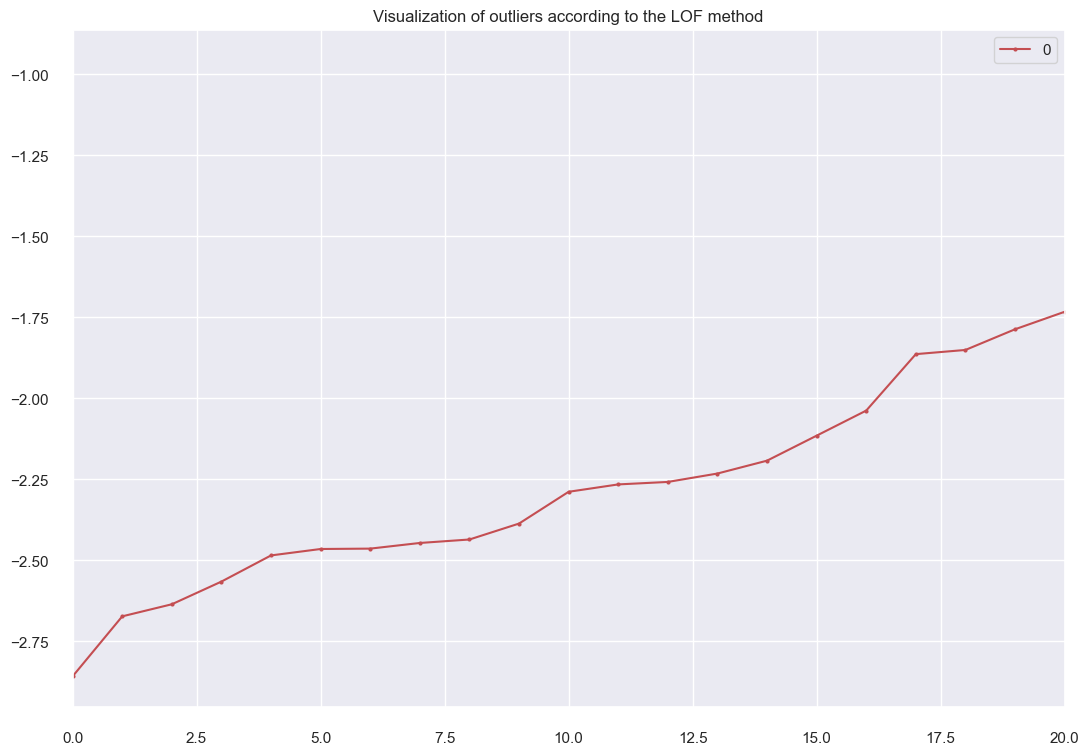

In [53]:
data_outlier = data_new.copy()
data_outlier = outlier_process(df = data_outlier)

## Feature Engineering

### Credit Score

In [54]:
def credit_score_table(row):
    credit_score = row.CreditScore
    if credit_score < 300:
        return "Deep"
    elif credit_score < 500:
        return "Very_Poor"
    elif credit_score < 601:
        return "Poor"
    elif credit_score < 661:
        return "Fair"
    elif credit_score < 781:
        return "Good"
    elif credit_score < 851:
        return "Excellent"
    else:
        return "Top"

### Age

In [55]:
def age_categorization(age):
    if age < 0:
        return "Invalid"
    elif age < 13:
        return "Child"
    elif age < 18:
        return "Teenager"
    elif age < 30:
        return "Young Adult"
    elif age < 60:
        return "Adult"
    else:
        return "Senior"

### Age and Tenure

In [56]:
def age_tenure(row):
    age = row.Age
    tenure = row.Tenure
    return age*tenure

### Product and Tenure

In [57]:
def product_utilization_rate_by_year(row):
    number_of_products = row.NumOfProducts
    tenure = row.Tenure
    
    if tenure == 0:
        return number_of_products
    else:
        rate = number_of_products / tenure
        return rate

### Product and Salary

In [58]:
def product_utilization_rate_by_estimated_salary(row):
    number_of_products = row.NumOfProducts
    estimated_salary = row.EstimatedSalary
    
    if estimated_salary == 0:
        return "Undefined"
    else:
        rate = number_of_products / estimated_salary
        return rate

### Geography and Salary

In [59]:
def countries_monthly_average_salaries(row):
    # Monthly average salary taken from https://www.worlddata.info/average-income.php
    avg_salaries = {'France': 3680, 'Germany': 4305, 'Spain': 2474}
    salary = row.EstimatedSalary / 12
    country = row.Geography
    
    if country in avg_salaries:
        return salary / avg_salaries[country]
    else:
        return None

### Balance and Salary

In [60]:
def balance_salary(row):
    balance = row.Balance
    salary = row.EstimatedSalary
    return balance/salary

### Credit Score Squared

In [61]:
def credit_score_squared(row):
    return (row.CreditScore)**2

### Mean Financial Condition (Financial Health)

In [62]:
def mean_financials(row):
    credit_score = row.CreditScore
    balance = row.Balance
    estimated_salary = row.EstimatedSalary
    
    mean_financials = (credit_score + balance + estimated_salary) / 3
    return mean_financials

### All Feature Engineering

In [63]:
def feature_engineering(df, is_show_graph=False):
    df_fe = df.copy()

    # balance_salary_rate
    df_fe['balance_salary_rate'] = df_fe.apply(lambda x: balance_salary(x), axis=1)

    # product_utilization_rate_by_year
    df_fe = df_fe.assign(product_utilization_rate_by_year=df_fe.apply(lambda x: product_utilization_rate_by_year(x), axis=1))

    # product_utilization_rate_by_estimated_salary
    df_fe = df_fe.assign(product_utilization_rate_by_estimated_salary=df_fe.apply(lambda x: product_utilization_rate_by_estimated_salary(x), axis=1))

    # tenure_rate_by_age
    df_fe['tenure_rate_by_age'] = df_fe.Tenure / (df_fe.Age - 17)

    # credit_score_rate_by_age
    df_fe['credit_score_rate_by_age'] = df_fe.CreditScore / (df_fe.Age - 17)

    # product_utilization_rate_by_salary
    df_fe['product_utilization_rate_by_salary'] = df_fe.Tenure / (df_fe.EstimatedSalary)

    # credit_score_rate_by_salary
    df_fe['credit_score_rate_by_salary'] = df_fe.CreditScore / (df_fe.EstimatedSalary)

    # mean_financials
    df_fe['mean_financials'] = df_fe.apply(lambda x: mean_financials(x), axis=1)

    # credit_score_squared
    df_fe['credit_score_squared'] = df_fe.apply(lambda x: credit_score_squared(x), axis=1)

    # age_tenure
    df_fe['age_tenure'] = df_fe.apply(lambda x: age_tenure(x), axis=1)

    # age_categorization
    df_fe['age_categorization'] = df_fe.Age.apply(lambda x: age_categorization(x))

    # credit_score_table
    df_fe = df_fe.assign(credit_score_table=df_fe.apply(lambda x: credit_score_table(x), axis=1))

    # countries_monthly_average_salaries
    df_fe = df_fe.assign(countries_monthly_average_salaries=df_fe.apply(lambda x: countries_monthly_average_salaries(x), axis=1))

    if is_show_graph:
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
        fig.tight_layout()
        sns.boxplot(y='balance_salary_rate', x=TARGET, hue=TARGET, data=df_fe, ax=axes[0][0])
        sns.boxplot(y='product_utilization_rate_by_year', x=TARGET, hue=TARGET, data=df_fe, ax=axes[0][1])
        plt.ylim(-1, 5)

    return df_fe

In [64]:
data_feature = feature_engineering(df = data_outlier)

In [65]:
data_feature.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,balance_salary_rate,product_utilization_rate_by_year,product_utilization_rate_by_estimated_salary,tenure_rate_by_age,credit_score_rate_by_age,product_utilization_rate_by_salary,credit_score_rate_by_salary,mean_financials,credit_score_squared,age_tenure,age_categorization,credit_score_table,countries_monthly_average_salaries
0,1,15634602,Hargrave,619,France,Female,42,2.00000,0.00000,1.00000,1,1,101348.88000,1,0.00000,0.50000,0.00001,0.08000,24.76000,0.00002,0.00611,33989.29333,383161,84.00000,Adult,Fair,2.29504
1,2,15647311,Hill,608,Spain,Female,41,1.00000,83807.86000,1.00000,0,1,112542.58000,0,0.74468,1.00000,0.00001,0.04167,25.33333,0.00001,0.00540,65652.81333,369664,41.00000,Adult,Fair,3.79084
2,3,15619304,Onio,502,France,Female,42,8.00000,159660.80000,3.00000,1,0,113931.57000,1,1.40137,0.37500,0.00003,0.32000,20.08000,0.00007,0.00441,91364.79000,252004,336.00000,Adult,Poor,2.57997
3,4,15701354,Boni,699,France,Female,39,1.00000,0.00000,2.00000,0,0,93826.63000,0,0.00000,2.00000,0.00002,0.04545,31.77273,0.00001,0.00745,31508.54333,488601,39.00000,Adult,Good,2.12470
4,5,15737888,Mitchell,850,Spain,Female,43,2.00000,125510.82000,1.00000,1,1,79084.10000,0,1.58706,0.50000,0.00001,0.07692,32.69231,0.00003,0.01075,68481.64000,722500,86.00000,Adult,Excellent,2.66384
5,6,15574012,Chu,645,Spain,Male,44,8.00000,113755.78000,2.00000,1,0,149756.71000,1,0.75960,0.25000,0.00001,0.29630,23.88889,0.00005,0.00431,88052.49667,416025,352.00000,Adult,Fair,5.04435
6,7,15592531,Bartlett,822,France,Male,50,7.00000,0.00000,2.00000,1,1,10062.80000,0,0.00000,0.28571,0.00020,0.21212,24.90909,0.00070,0.08169,3628.26667,675684,350.00000,Adult,Excellent,0.22787
7,8,15656148,Obinna,383,Germany,Female,29,4.00000,115046.74000,4.00000,1,0,119346.88000,1,0.96397,1.00000,0.00003,0.33333,31.91667,0.00003,0.00321,78258.87333,146689,116.00000,Young Adult,Very_Poor,2.31024
8,9,15792365,He,501,France,Male,44,4.00000,142051.07000,2.00000,0,1,74940.50000,0,1.89552,0.50000,0.00003,0.14815,18.55556,0.00005,0.00669,72497.52333,251001,176.00000,Adult,Poor,1.69702
9,10,15592389,H?,684,France,Male,27,2.00000,134603.88000,1.00000,1,1,71725.73000,0,1.87665,0.50000,0.00001,0.20000,68.40000,0.00003,0.00954,69004.53667,467856,54.00000,Young Adult,Good,1.62422


## Data Encoding

In [66]:
def data_encoding(df):
    df_model = df.copy()
    
    # Categorical columns
    non_encoding_columns = ["Geography", "HasCrCard", "IsActiveMember", "Gender", "NumOfProducts", "Tenure", "credit_score_table","age_categorization"]
    df_non_encoding = df_model[non_encoding_columns]
    df_model = df_model.drop(non_encoding_columns, axis=1)
    
    df_encoding = df_non_encoding.copy()
    
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    df_encoding["gender_category"] = encoder.fit_transform(df_non_encoding.Gender)
    df_encoding["country_category"] = encoder.fit_transform(df_non_encoding.Geography)
    df_encoding["credit_score_category"] = encoder.fit_transform(df_non_encoding.credit_score_table)
    df_encoding["age_category"] = encoder.fit_transform(df_non_encoding.age_categorization)

    df_encoding.reset_index(drop=True, inplace=True)
    df_model.reset_index(drop=True, inplace=True)
    df_model = pd.concat([df_model, df_encoding], axis=1)

    # Drop unnecessary columns
    df_model = df_model.drop(["Geography", "Gender", "CustomerId", "Surname", "credit_score_table","age_categorization"], axis=1)

    # Encode HasCrCard and IsActiveMember as -1 for 0 values
    df_model.loc[df_model.HasCrCard == 0, 'HasCrCard'] = -1
    df_model.loc[df_model.IsActiveMember == 0, 'IsActiveMember'] = -1

    return df_model

In [67]:
data_encoded = data_encoding(data_feature)
data_encoded.head(20)

,RowNumber,CreditScore,Age,Balance,EstimatedSalary,Exited,balance_salary_rate,product_utilization_rate_by_year,product_utilization_rate_by_estimated_salary,tenure_rate_by_age,credit_score_rate_by_age,product_utilization_rate_by_salary,credit_score_rate_by_salary,mean_financials,credit_score_squared,age_tenure,countries_monthly_average_salaries,HasCrCard,IsActiveMember,NumOfProducts,Tenure,gender_category,country_category,credit_score_category,age_category
0,1,619,42,0.00000,101348.88000,1,0.00000,0.50000,0.00001,0.08000,24.76000,0.00002,0.00611,33989.29333,383161,84.00000,2.29504,1,1,1.00000,2.00000,0,0,1,0
1,2,608,41,83807.86000,112542.58000,0,0.74468,1.00000,0.00001,0.04167,25.33333,0.00001,0.00540,65652.81333,369664,41.00000,3.79084,-1,1,1.00000,1.00000,0,2,1,0
2,3,502,42,159660.80000,113931.57000,1,1.40137,0.37500,0.00003,0.32000,20.08000,0.00007,0.00441,91364.79000,252004,336.00000,2.57997,1,-1,3.00000,8.00000,0,0,3,0
3,4,699,39,0.00000,93826.63000,0,0.00000,2.00000,0.00002,0.04545,31.77273,0.00001,0.00745,31508.54333,488601,39.00000,2.12470,-1,-1,2.00000,1.00000,0,0,2,0
4,5,850,43,125510.82000,79084.10000,0,1.58706,0.50000,0.00001,0.07692,32.69231,0.00003,0.01075,68481.64000,722500,86.00000,2.66384,1,1,1.00000,2.00000,0,2,0,0
5,6,645,44,113755.78000,149756.71000,1,0.75960,0.25000,0.00001,0.29630,23.88889,0.00005,0.00431,88052.49667,416025,352.00000,5.04435,1,-1,2.00000,8.00000,1,2,1,0
6,7,822,50,0.00000,10062.80000,0,0.00000,0.28571,0.00020,0.21212,24.90909,0.00070,0.08169,3628.26667,675684,350.00000,0.22787,1,1,2.00000,7.00000,1,0,0,0
7,8,383,29,115046.74000,119346.88000,1,0.96397,1.00000,0.00003,0.33333,31.91667,0.00003,0.00321,78258.87333,146689,116.00000,2.31024,1,-1,4.00000,4.00000,0,1,4,2
8,9,501,44,142051.07000,74940.50000,0,1.89552,0.50000,0.00003,0.14815,18.55556,0.00005,0.00669,72497.52333,251001,176.00000,1.69702,-1,1,2.00000,4.00000,1,0,3,0
9,10,684,27,134603.88000,71725.73000,0,1.87665,0.50000,0.00001,0.20000,68.40000,0.00003,0.00954,69004.53667,467856,54.00000,1.62422,1,1,1.00000,2.00000,1,0,2,2


## Correlation Analysis

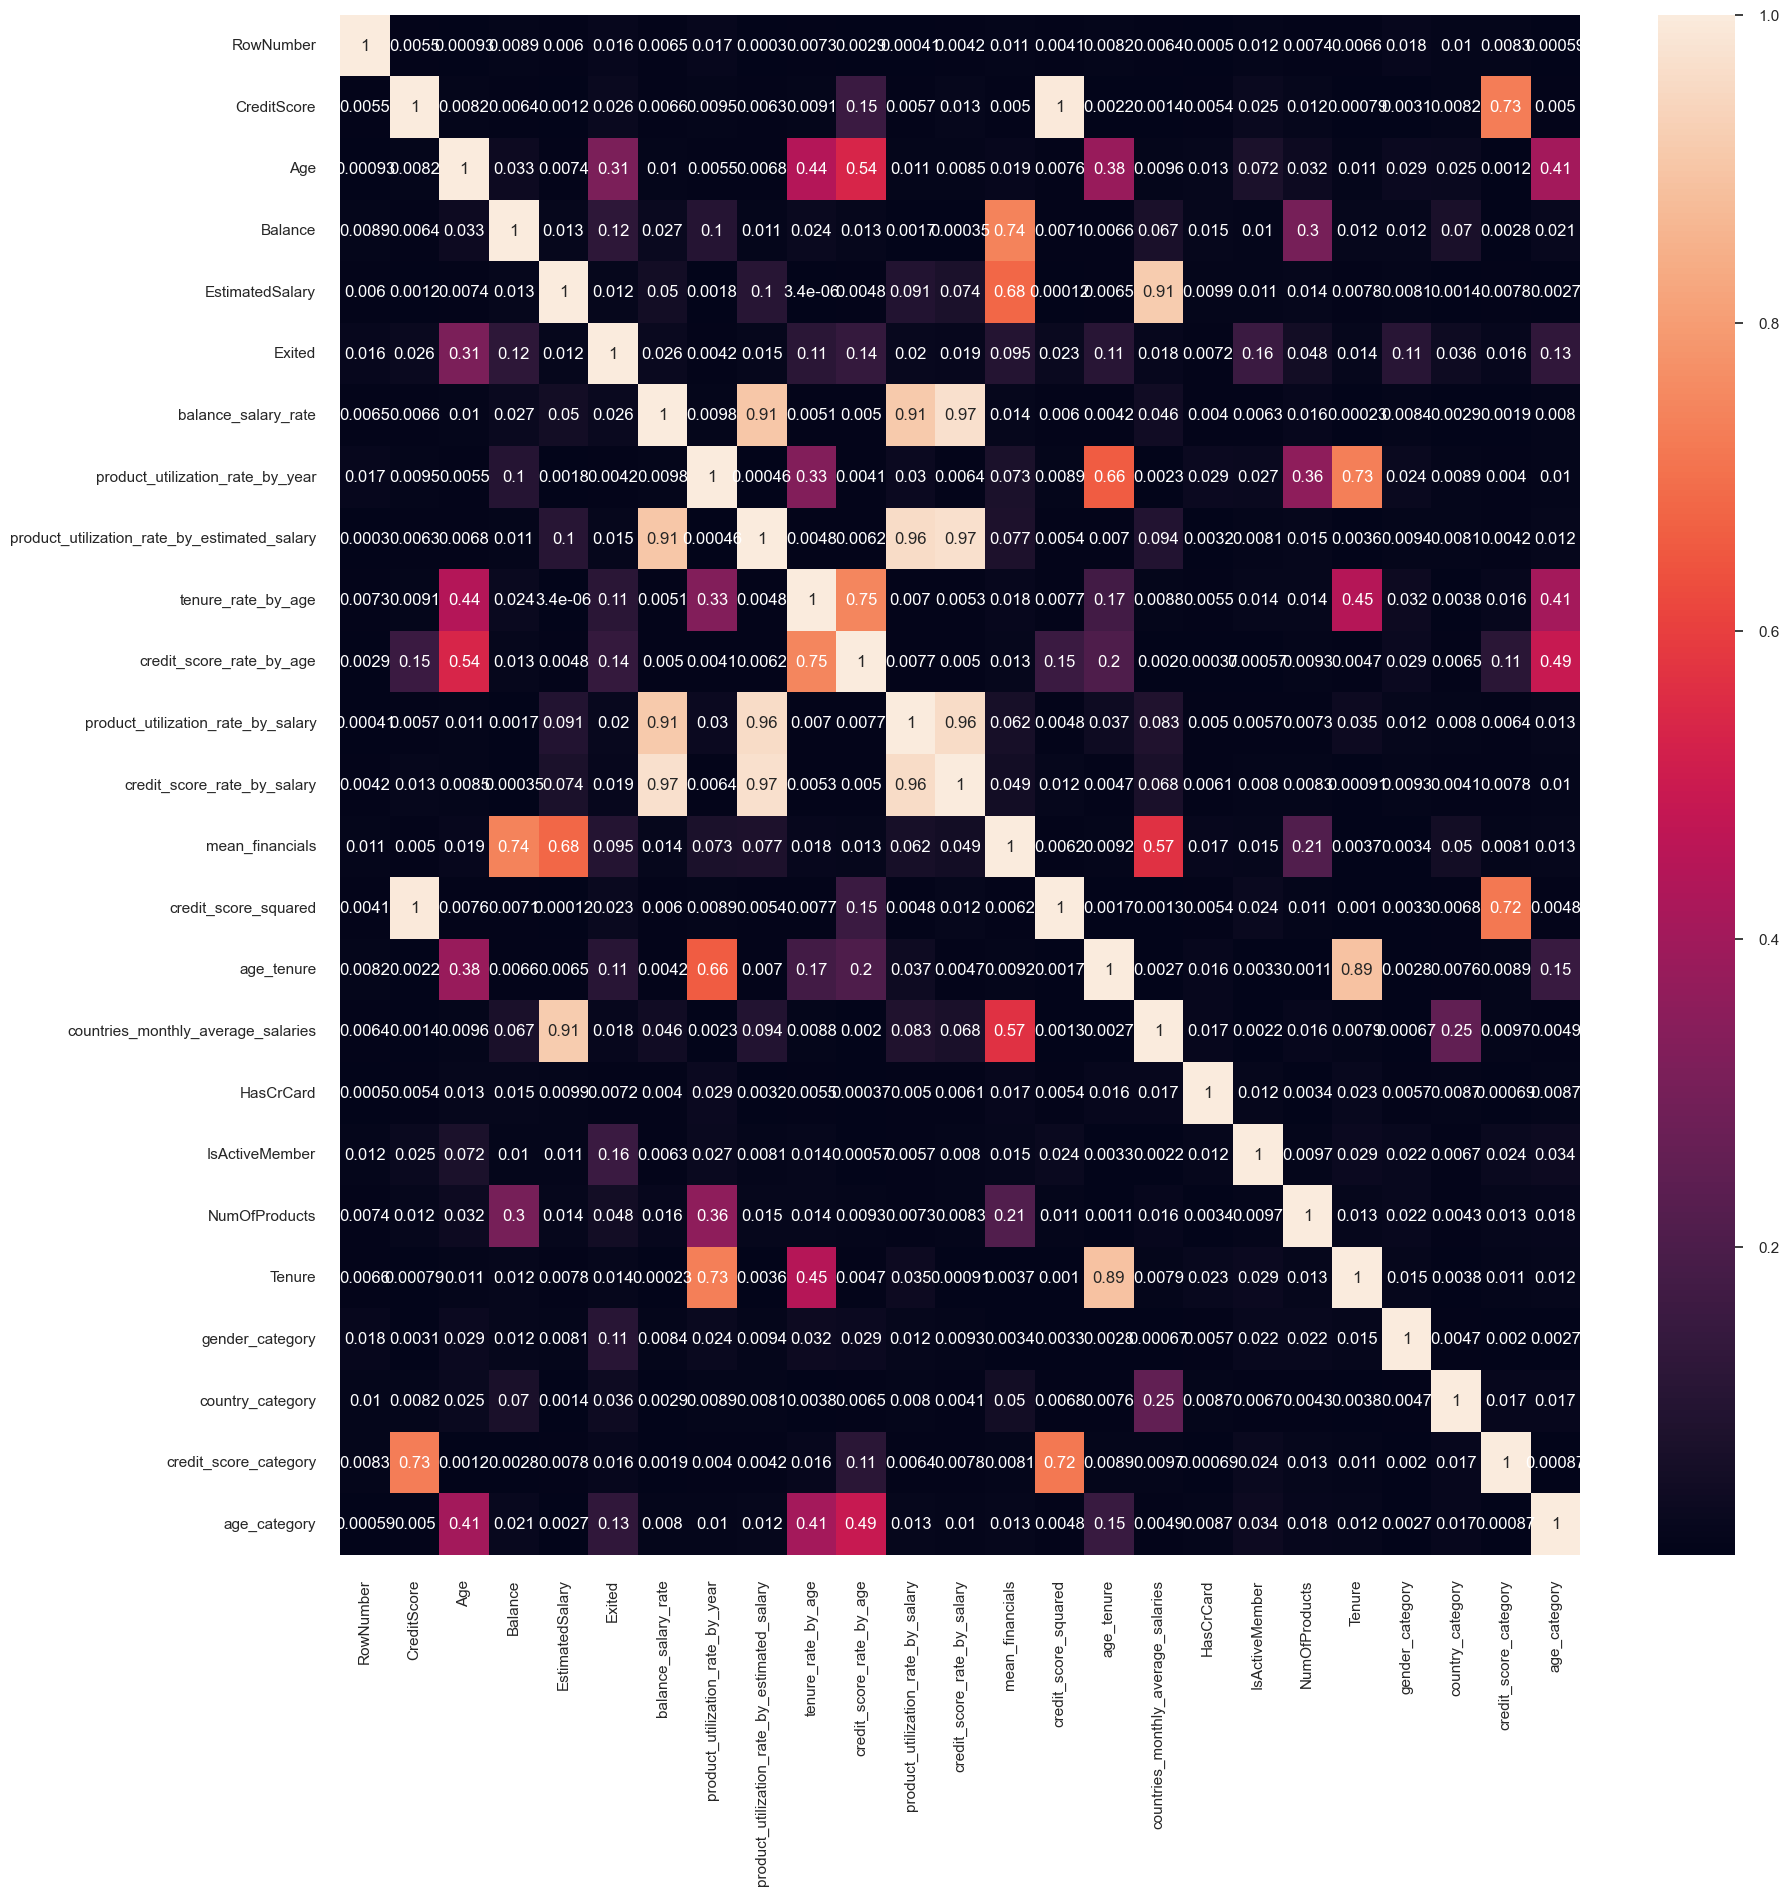

In [68]:
correlation = data_encoded.corr().abs()
plt.figure(figsize=(20,20))
sns.heatmap(correlation, annot=True)
plt.show()

In [69]:
corrs_results = data_encoded.corrwith(data_encoded["Exited"]).abs().nlargest(24)
corrs_results

Exited                                         1.00000
Age                                            0.31293
IsActiveMember                                 0.15588
credit_score_rate_by_age                       0.13949
age_category                                   0.12634
Balance                                        0.11865
tenure_rate_by_age                             0.11274
age_tenure                                     0.10626
gender_category                                0.10624
mean_financials                                0.09481
NumOfProducts                                  0.04775
country_category                               0.03575
CreditScore                                    0.02617
balance_salary_rate                            0.02557
credit_score_squared                           0.02347
product_utilization_rate_by_salary             0.02030
credit_score_rate_by_salary                    0.01918
countries_monthly_average_salaries             0.01811
RowNumber 

## Model Utilization

In [70]:
def model_prepare(df_model):
    y = df_model[TARGET]
    X = df_model.drop(TARGET, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32)
    
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [71]:
# model_prepare test, train split 0.3
X_train, X_test, y_train, y_test = model_prepare(df_model = data_encoded)

### Logistic Regression

In [72]:
logr_model = LogisticRegression()
logr_model.fit(X_train, y_train)
y_pred = logr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(classification_report(y_test, y_pred, digits=4))
print(f"Accuracy score of Logistic Regression: {accuracy:.4f}")

              precision    recall  f1-score   support

           0     0.8260    0.9696    0.8920      2365
           1     0.6786    0.2394    0.3539       635

    accuracy                         0.8150      3000
   macro avg     0.7523    0.6045    0.6230      3000
weighted avg     0.7948    0.8150    0.7781      3000

Accuracy score of Logistic Regression: 0.8150


### Model with Training

In [73]:
def data_training(X_train, X_test, y_train, y_test):
    models = [
        ('LOGR', LogisticRegression()),
        ('KNN', KNeighborsClassifier()),
        ('CART', DecisionTreeClassifier()),
        ('RF', RandomForestClassifier()),
        ('GBM', GradientBoostingClassifier()),
        ('XGBoost', XGBClassifier()),
        ('LightGBM', LGBMClassifier()),
        ('CatBoost', CatBoostClassifier(verbose=0))
    ]

    df_result = pd.DataFrame(columns=["model", "accuracy_score", "scale_method", "0_precision", "0_recall", "1_precision", "1_recall"])
    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, digits=2, output_dict=True)
        zero_report = class_report['0']
        one_report = class_report['1']
        df_result = pd.concat([df_result, pd.DataFrame({
            'model': [name],
            'accuracy_score': [score],
            'scale_method': ['NA'],
            '0_precision': [zero_report['precision']],
            '0_recall': [zero_report['recall']],
            '1_precision': [one_report['precision']],
            '1_recall': [one_report['recall']]
        })], ignore_index=True)

    return df_result.sort_values("accuracy_score", ascending=False)

In [74]:
training_result = data_training(X_train, X_test, y_train, y_test)
training_result

[LightGBM] [Info] Number of positive: 1401, number of negative: 5596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3659
[LightGBM] [Info] Number of data points in the train set: 6997, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200229 -> initscore=-1.384866
[LightGBM] [Info] Start training from score -1.384866


,model,accuracy_score,scale_method,0_precision,0_recall,1_precision,1_recall
6,LightGBM,0.85333,NA,0.87524,0.94926,0.72414,0.49606
7,CatBoost,0.85300,NA,0.87057,0.95560,0.74010,0.47087
4,GBM,0.85100,NA,0.86659,0.95856,0.74479,0.45039
3,RF,0.84667,NA,0.86286,0.95772,0.73333,0.43307
5,XGBoost,0.84200,NA,0.87006,0.93996,0.68090,0.47717
0,LOGR,0.81500,NA,0.82601,0.96956,0.67857,0.23937
1,KNN,0.81067,NA,0.83816,0.94165,0.59767,0.32283
2,CART,0.78967,NA,0.87051,0.86131,0.50303,0.52283


## Hyperparameter Tuning

### XGBoost

In [75]:

xgb_model = XGBClassifier(objective='reg:logistic', eval_metric="logloss")

param_grid = {
    'learning_rate': [0.3, 0.31, 0.32],
    'max_depth': [5,6,7],
    'n_estimators': [30,40, 50]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)


Best parameters:  {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 30}


In [76]:
xgb_model=XGBClassifier(silent=0, learning_rate=0.31, max_delta_p=5,
                            objective='reg:logistic',n_estimators=30, 
                            max_depth=3, eval_metric="logloss", gamma=3,base_score=0.5)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test,y_pred,digits=2))
print("Accuracy score of Tuned XGBoost Regression: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2365
           1       0.75      0.45      0.56       635

    accuracy                           0.85      3000
   macro avg       0.81      0.71      0.74      3000
weighted avg       0.84      0.85      0.84      3000

Accuracy score of Tuned XGBoost Regression:  0.8523333333333334


### Random Forest

In [77]:
# param_grid = {'max_depth': [6, 7, 8], 'max_features': [7,8,9],'n_estimators' : [50,100], 'min_samples_split': [5, 6, 7]}
# randFor_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv = 3, refit = True, verbose = 0)
# randFor_grid.fit(X_train,y_train)
# y_pred = randFor_grid.predict(X_test)
# print(classification_report(y_test,y_pred,digits=2))
# print("Accuracy score of tuned Random Forest model: ", accuracy_score(y_test, y_pred))

In [78]:
# rnd_model = RandomForestClassifier(max_depth=10, max_features=14, min_samples_split=11,n_estimators=75)
# rnd_model.fit(X_train, y_train)
# y_pred = rnd_model.predict(X_test)
# print(classification_report(y_test,y_pred,digits=2))
# print("Accuracy score of tuned Random Forest model: ", accuracy_score(y_test, y_pred))

### LightBGM

In [79]:
lgbm_model = LGBMClassifier(silent = 0, learning_rate = 0.08, max_delta_step = 1, n_estimators = 45, boosting_type = 'gbdt',
                            max_depth = 5)
lgbm_model.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=2))
print("Accuracy score of tuned LightGBM model: ", accuracy_score(y_test, y_pred))

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 1401, number of negative: 5596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3659
[LightGBM] [Info] Number of data points in the train set: 6997, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200229 -> initscore=-1.384866
[LightGBM] [Info] Start training from score -1.384866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

## Parameter and More Function

In [80]:
# Function to display the best model score and parameters
def display_best_model(model):
    print(f"Best score: {model.best_score_}")
    print(f"Best parameters: {model.best_params_}")
    print(f"Best estimator: {model.best_estimator_}")

# Function to calculate AUC score and ROC curve
def calculate_auc_scores(y_actual, y_pred_prob):
    auc_score = roc_auc_score(y_actual, y_pred_prob)
    fpr, tpr, _ = roc_curve(y_actual, y_pred_prob)
    return auc_score, fpr, tpr

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.rcParams.update({'font.size': 16})
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, color="blue")
    plt.yticks(tick_marks, classes, color="blue")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Function to handle infinite values in a DataFrame
def handle_infinite_values(df):
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

### Confussion Matrix

Confusion matrix, without normalization
[[2284   81]
 [ 358  277]]
True Negatives:  2284
False Positives:  81
False Negatives:  358
True Positives:  277


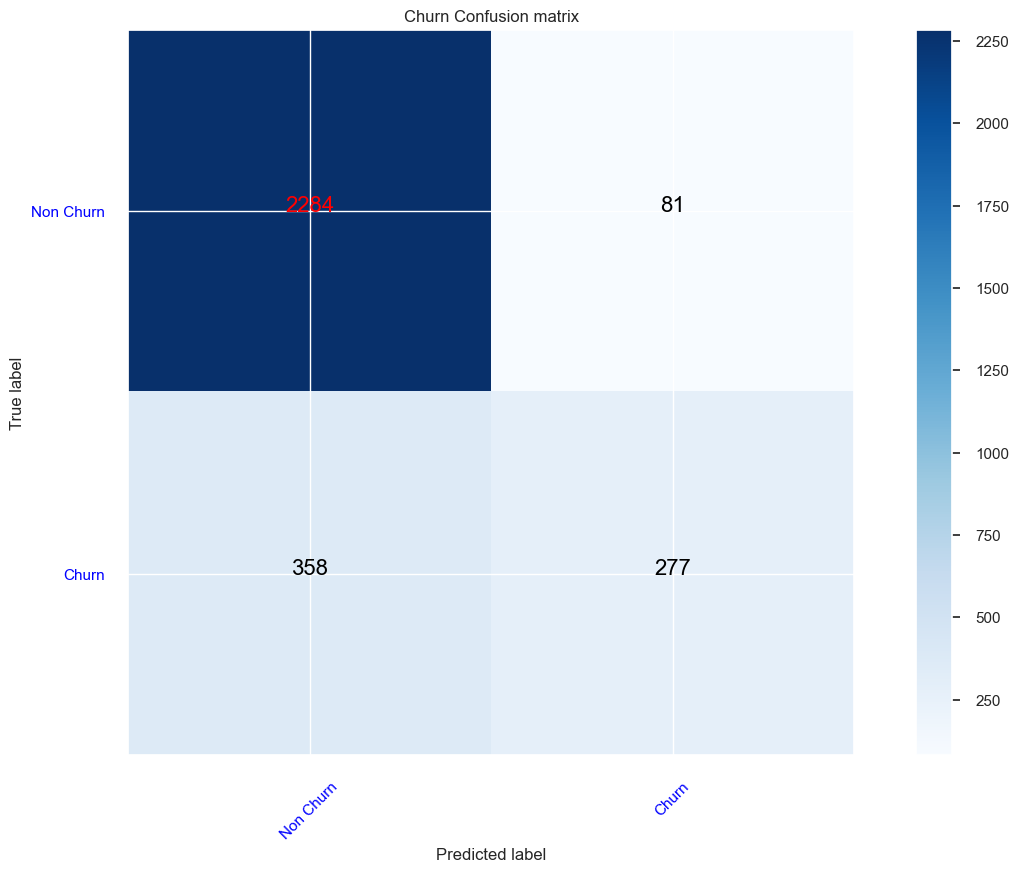

In [81]:
cfm = confusion_matrix(y_test, y_pred=y_pred)
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='Churn Confusion matrix')


tn, fp, fn, tp = cfm.ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

### ROC Curve

[LightGBM] [Warning] Unknown parameter: silent


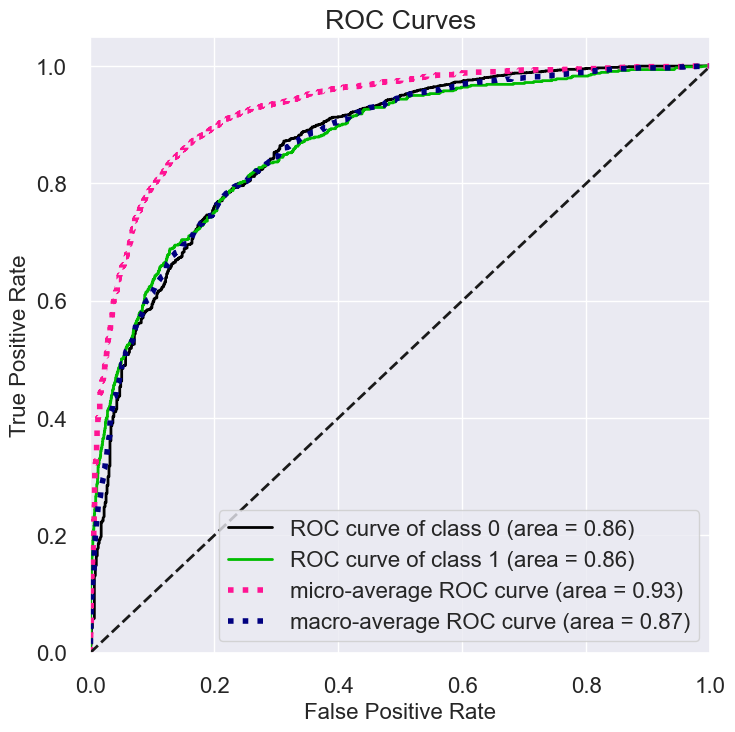

In [82]:
y_pred_proba = lgbm_model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_proba, figsize=(8,8))

plt.show()

### Feature Importance

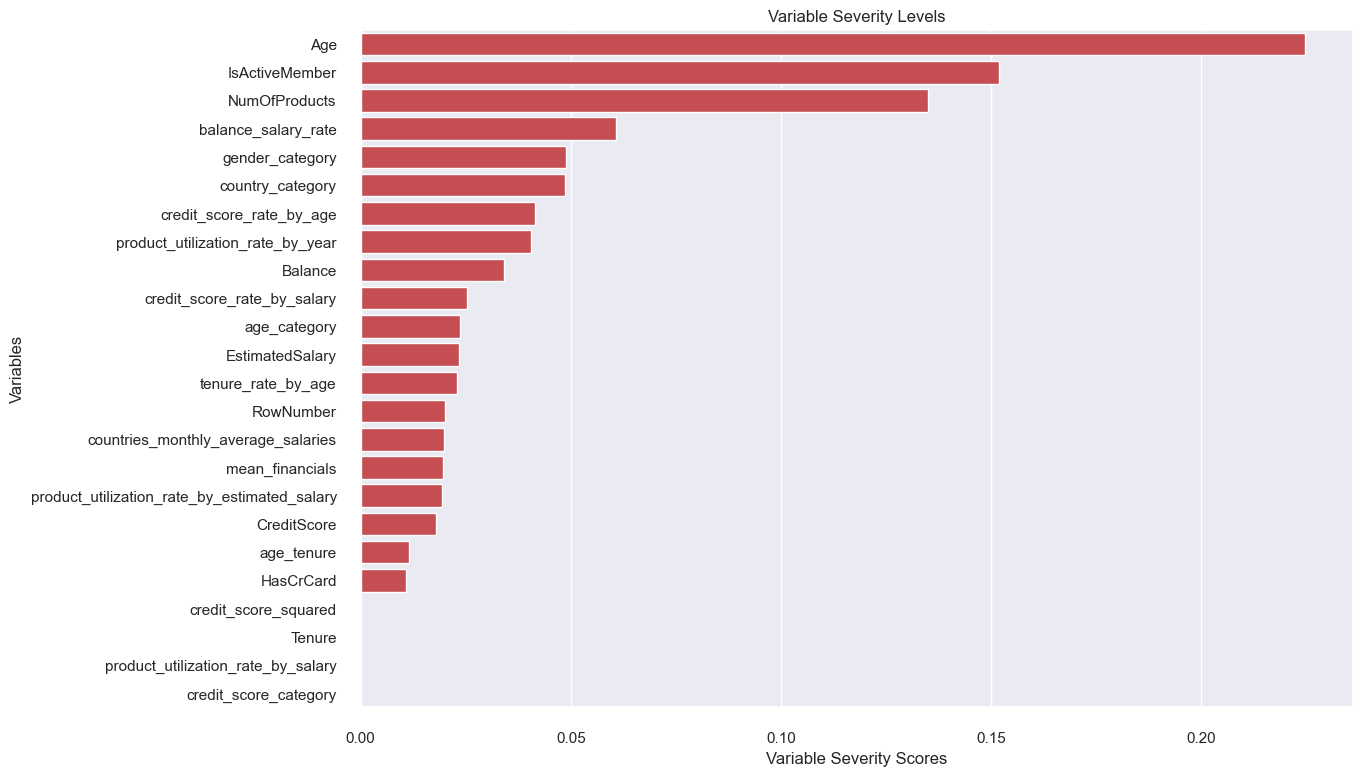

In [83]:
feature_index = data_encoded.loc[:, data_encoded.columns != TARGET]

feature_importance = pd.Series(xgb_model.feature_importances_, 
                               index=feature_index.columns).sort_values(ascending=False)
sns.barplot(x = feature_importance, y = feature_importance.index, color='r', saturation=1)
plt.xlabel('Variable Severity Scores')
plt.ylabel('Variables')
plt.title('Variable Severity Levels')
plt.show()

## Pipeline

In [84]:
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = model_prepare(df_model = data_encoded)

pipe = Pipeline([('xgboost', xgb_model)])

pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)

print(classification_report(y_test,y_pred,digits=2))
print("Accuracy score of Tuned XGBoost Regression: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2365
           1       0.75      0.45      0.56       635

    accuracy                           0.85      3000
   macro avg       0.81      0.71      0.74      3000
weighted avg       0.84      0.85      0.84      3000

Accuracy score of Tuned XGBoost Regression:  0.8523333333333334


In [85]:
with open('pipeline.pickle','wb') as f:
    pickle.dump(pipe, f)

with open('pipeline.pickle','rb') as f:
    loaded_pipe = pickle.load(f)
    
y_pred = loaded_pipe.predict(X_test)

print(classification_report(y_test,y_pred,digits=2))
print("Accuracy score of Tuned XGBoost Regression: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2365
           1       0.75      0.45      0.56       635

    accuracy                           0.85      3000
   macro avg       0.81      0.71      0.74      3000
weighted avg       0.84      0.85      0.84      3000

Accuracy score of Tuned XGBoost Regression:  0.8523333333333334


In [86]:
def prediction(model, df):
    data_feature = feature_engineering(df)
    data_encoded = data_encoding(data_feature)
    
    prediction = model.predict(data_encoded)
    
    df['ExitedPred'] = prediction.tolist()

    return prediction

In [87]:
results =prediction(loaded_pipe,data_outlier.drop(TARGET, axis=1))

results[0]

0

In [88]:
print(prediction)

<function prediction at 0x000002541D474680>


In [89]:
with open('churn_model.pkl','wb') as f:
    pickle.dump(xgb_model, f)

with open('churn_model.pkl','rb') as f:
    loaded_pipe = pickle.load(f)
    
y_pred = loaded_pipe.predict(X_test)

print(classification_report(y_test,y_pred,digits=2))
print("Accuracy score of Tuned XGBoost Regression: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2365
           1       0.75      0.45      0.56       635

    accuracy                           0.85      3000
   macro avg       0.81      0.71      0.74      3000
weighted avg       0.84      0.85      0.84      3000

Accuracy score of Tuned XGBoost Regression:  0.8523333333333334


In [90]:
test = data.drop("Exited", axis=1).iloc[4].to_dict()
test

{'RowNumber': 5,
 'CustomerId': 15737888,
 'Surname': 'Mitchell',
 'CreditScore': 850,
 'Geography': 'Spain',
 'Gender': 'Female',
 'Age': 43,
 'Tenure': 2,
 'Balance': 125510.82,
 'NumOfProducts': 1,
 'HasCrCard': 1,
 'IsActiveMember': 1,
 'EstimatedSalary': 79084.1}